In [1]:
# Import utils
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from matplotlib.patches import PathPatch

# Data-Driven Patient Scheduling modules
from DataDrivenPatientScheduling.WeightsModel import WeightsModel
from DataDrivenPatientScheduling.Experiment import Experiment
from DataDrivenPatientScheduling.Evaluation import Evaluation

In [2]:
## Type of run
#run_suffix = 'xArea'
#run_suffix = 'xCapacity'
run_suffix = 'xCapacity_xArea'

In [3]:
# Setup experiment
experiment_setup = dict(

    # Paths
    path_data = '/home/fesc/dddex/PatientScheduling/Data',
    path_models = '/home/fesc/dddex/PatientScheduling/Data/Models',
    path_results = '/home/fesc/dddex/PatientScheduling/Data/Results',
    
    # Models
    models = dict(
        LSx_LGBM = 'LSx_LGBM',
        LSx_NN_LGBM = 'LSx_NN_LGBM',
        wSAA_RF = 'wSAA_RF',
        SAA_by_area = 'SAA_by_area',
        SAA = 'SAA'
    ),
    
    # Number of scenarios
    K = [10**2, 10**3, 10**4],

    # Time budget multiplier
    rho = [0.85, 1.00, 1.15],

    # n parallel jobs
    n_jobs = 32
)

# Make all experiment variables visible locally
locals().update(experiment_setup)

# Pre-processing

In [4]:
# Load and combine all data
results = pd.DataFrame()
for model in models:

    # Read
    result = pd.read_csv(path_results+'/'+model+'_'+run_suffix+'.csv', sep=',')
    result['model'] = copy.deepcopy(model)

    results = pd.concat([results, result])
        
# Finalize
results = results.reset_index(drop=True)

In [5]:
# Baseline
results = pd.merge(
    left = results.loc[results.model != 'SAA'],
    right = results.loc[results.model == 'SAA', 
                        ['n_scenarios', 'utilization', 'c_waiting_time', 'c_overtime', 'date', 'area', 'room', 'cost']],
    on = ['n_scenarios', 'utilization', 'c_waiting_time', 'c_overtime', 'date', 'area', 'room'],
    suffixes = ('', '_SAA')
)

# Cost performance

In [6]:
# Select data
K_ = 10**4
models_ = ['wSAA_RF', 'LSx_LGBM', 'LSx_NN_LGBM']
min_patients_ = 2

# Set labels
labels = pd.DataFrame({'model': ['wSAA_RF', 'LSx_LGBM', 'LSx_NN_LGBM'], 
                       'order': [1, 2, 3], 
                       'label': ['wSAA RF', 'LSx LGBM', 'LSx NN LGBM']})

## Cost per room per day

In [7]:
# Prepare data
plotData = results.loc[
    (results.model.isin(models_)) & 
    (results.n_scenarios == K_) & 
    (results.n_patients >= min_patients_)].copy()

plotData['copres'] = plotData.cost / plotData.cost_SAA
plotData.loc[plotData.cost == plotData.cost_SAA, 'copres'] = 1.0
plotData = plotData.loc[~np.isinf(plotData.copres)].copy()

plotData = pd.merge(
    left=plotData,
    right=labels,
    on='model'
)

plotData = plotData.sort_values('order')

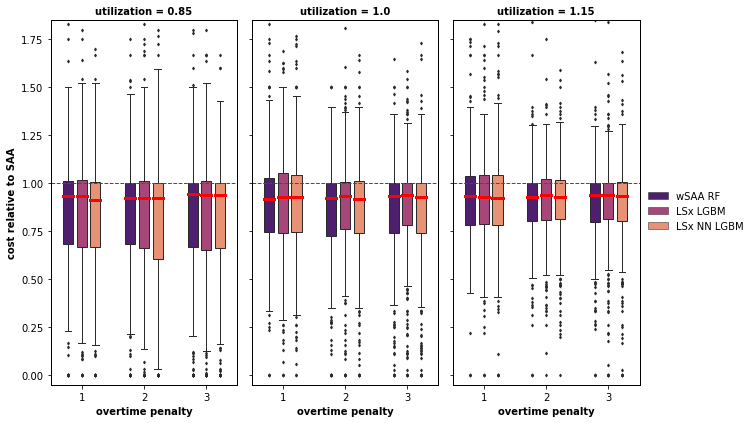

In [8]:
# Plot
evaluation = Evaluation()
fig = evaluation.plot_prescriptive_performance(
    plotData=plotData, grid_var='utilization', x_var='c_overtime', y_var='copres', hue_var='label',
    kind='medians', ylim=(-0.05, 1.85), facet_h=6, facet_w=3, fliersize=2, whis=1.5)

In [9]:
# Save
fig.savefig(path_results+'/Plots/prescriptive_performance_'+run_suffix+'_K'+str(K_)+'_medians.pdf')  

In [10]:
# Table
tableData = plotData.groupby(

    [
        'utilization', 
        'c_overtime', 
        'label'
    ]
    
).agg(

    copres = ('copres', np.median)
    
).reset_index()

tableData.pivot(index='label', columns=['utilization', 'c_overtime'], values='copres')

utilization      0.85                          1.00                      \
c_overtime          1         2         3         1         2         3   
label                                                                     
LSx LGBM     0.932432  0.923077  0.938697  0.930481  0.933834  0.937996   
LSx NN LGBM  0.912806  0.925234  0.940469  0.929078  0.920000  0.929978   
wSAA RF      0.936508  0.923077  0.946121  0.920792  0.921767  0.934066   

utilization      1.15                      
c_overtime          1         2         3  
label                                      
LSx LGBM     0.926829  0.938354  0.940245  
LSx NN LGBM  0.921310  0.926898  0.933610  
wSAA RF      0.934959  0.926471  0.937594

## Total cost

In [11]:
# Prepare data
plotData = results.loc[
    (results.model.isin(models_)) & 
    (results.n_scenarios == K_) & 
    (results.n_patients >= min_patients_)].copy()

plotData = plotData.groupby(['utilization', 'c_overtime', 'model']).agg(
    cost=('cost', sum),
    cost_SAA=('cost_SAA', sum)
).reset_index()

plotData['copres'] = plotData.cost / plotData.cost_SAA

plotData = pd.merge(
    left=plotData,
    right=labels,
    on='model'
)

plotData = plotData.sort_values('order')

/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.316654, 0.07169, 0.48538)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.716387, 0.214982, 0.47529)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.9867, 0.535582, 0.38221)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: Y

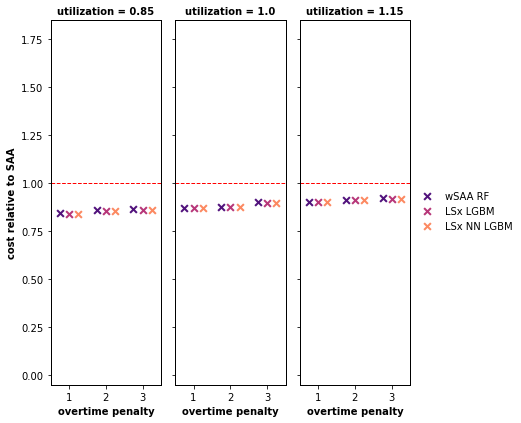

In [12]:
# Plot
evaluation = Evaluation()
fig = evaluation.plot_prescriptive_performance(
    plotData=plotData, grid_var='utilization', x_var='c_overtime', y_var='copres', hue_var='label',
    kind='totals', ylim=(-0.05, 1.85), facet_h=6, facet_w=2)

In [13]:
# Save
fig.savefig(path_results+'/Plots/prescriptive_performance_'+run_suffix+'_K'+str(K_)+'_totals.pdf')  

In [14]:
# Table
plotData.pivot(index='label', columns=['utilization', 'c_overtime'], values='copres')

utilization      1.15                1.00                          0.85  \
c_overtime          3         1         3         2         1         3   
label                                                                     
LSx LGBM     0.920150  0.902246  0.897598  0.875710  0.871928  0.859305   
LSx NN LGBM  0.919625  0.903114  0.896496  0.877122  0.870100  0.860260   
wSAA RF      0.922484  0.903681  0.901444  0.878167  0.872619  0.865007   

utilization                          1.15  
c_overtime          2         1         2  
label                                      
LSx LGBM     0.856899  0.841863  0.913573  
LSx NN LGBM  0.855839  0.840964  0.911524  
wSAA RF      0.863602  0.846463  0.915039

## Stats

In [15]:
# Significance test

In [16]:
# Prepare data
statsData = results.loc[
    (results.model.isin(models_)) & 
    (results.n_scenarios == K_) & 
    (results.n_patients >= min_patients_)].copy()

statsData['copres'] = statsData.cost / statsData.cost_SAA
statsData.loc[statsData.cost == statsData.cost_SAA, 'copres'] = 1.0

In [17]:
evaluation = Evaluation()
evaluation.differences(statsData, cost_var='cost', copres_var='copres', 
                       groups=['utilization', 'c_overtime'], test='unpaired', 
                       alternative='two-sided', n_hypotheses=1)

/home/fesc/dddex/PatientScheduling/Code/DataDrivenPatientScheduling/Evaluation.py:297: RuntimeWarning: invalid value encountered in subtract


,utilization,c_overtime,model,benchmark,difference_of_means,difference_of_medians,share_model_is_better,statistic,pvalue,sig0001,sig0010,sig0050
0,0.85,1,LSx_LGBM,LSx_NN_LGBM,0.040286,0.019864,0.315789,41290.0,0.730154,,,
1,0.85,1,LSx_LGBM,wSAA_RF,0.044595,-0.006216,0.429577,40398.5,0.971412,,,
2,0.85,1,LSx_NN_LGBM,LSx_LGBM,-0.040286,-0.019864,0.329825,39935.0,0.730154,,,
3,0.85,1,LSx_NN_LGBM,wSAA_RF,0.004153,-0.022497,0.428070,40037.0,0.769605,,,
4,0.85,1,wSAA_RF,LSx_LGBM,-0.044595,0.006216,0.334507,40257.5,0.971412,,,
5,0.85,1,wSAA_RF,LSx_NN_LGBM,-0.004153,0.022497,0.350877,41188.0,0.769605,,,
6,0.85,2,LSx_LGBM,LSx_NN_LGBM,0.010570,-0.001078,0.353147,41480.5,0.768161,,,
7,0.85,2,LSx_LGBM,wSAA_RF,0.016297,0.003205,0.444056,41852.0,0.629163,,,
8,0.85,2,LSx_NN_LGBM,LSx_LGBM,-0.010570,0.001078,0.300699,40315.5,0.768161,,,
9,0.85,2,LSx_NN_LGBM,wSAA_RF,0.005707,0.002157,0.435540,41629.5,0.822773,,,


# <<<<< ARCHIVE >>>>>

In [ ]:
magma = sns.color_palette('magma')
magma

In [ ]:
viridis = sns.color_palette('viridis')
viridis

In [ ]:
palette = {"wSAA RF": magma[2],
           "LSx LGBM": viridis[3], 
           "LSx NN LGBM": magma[5]}

In [ ]:
palette = {"wSAA RF":"tab:cyan",
           "LSx LGBM":"tab:orange", 
           "LSx NN LGBM":"tab:purple"}


In [ ]:
#### ... 
def predict_quantiles(X, y, date, dates, areas, weightsModel = None, 
             quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995],
             print_status = False):



    """

    ...

    Arguments:

        X: ...
        y: ...
        date: ...
        dates: ...
        areas: ...
        weightsModel = None: ...
        quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.900, 0.975, 0.995]: ...
        print_status = True: ...

    Returns:

        results(pd.DataFrame): ...


    """

    # Train-test split
    y_train, y_test = y[dates < date].flatten(), y[dates == date].flatten()
    X_train, X_test = X[dates < date], X[dates == date]
    dates_train, dates_test = dates[dates < date], dates[dates == date]
    areas_train, areas_test = areas[dates < date], areas[dates == date]

    # Fit weights model
    weightsModel.fit(X_train, y_train)

    # Initialize
    results = {}

    # For each area 
    for area in list(set(areas_test)):

        # Select test data for current area
        y_test_ = y_test[area == areas_test]
        X_test_ = X_test[area == areas_test]

        # Fit SAA on data of current area
        SAA = SampleAverageApproximation()
        SAA.fit(y_train[area == areas_train])

        # Predict quantiles for each patient
        q_hat = weightsModel.predict(X_test_, probs=quantiles, outputAsDf=False)
        q_hat_saa = SAA.predict(X_test_, probs=quantiles, outputAsDf=False)

        # Add to results
        results[area] = pd.merge(
            left = pd.concat(pd.DataFrame({'prob': p, 'q_hat': q}) for p, q in q_hat.items()).reset_index(names='j'),
            right = pd.concat(pd.DataFrame({'prob': p, 'q_hat_saa': q, 'y': y_test_}) for p, q in q_hat_saa.items()).reset_index(names='j'),
            on = ['prob', 'j']
        )
        
    # Finalize
    results = pd.concat(results).reset_index(names=['area', '']).drop(columns='')

    return results

In [ ]:
# Update params
locals().update(optimization_params)

# Test dates
dates = pd.Series(list(set(ID_data.loc[ID_data.train_test == 'test', 'date']))).sort_values()

# Timer
start_time, st_exec, st_cpu = dt.datetime.now().replace(microsecond=0), time.time(), time.process_time()      
        
# For each date in the test horizon
with experiment.tqdm_joblib(tqdm(desc='Progress', total=len(dates))) as progress_bar:
    results = Parallel(n_jobs=n_jobs)(delayed(predict_quantiles)(
        X = np.array(X_data),
        y = np.array(Y_data),
        date = date,
        dates = ID_data['date'],
        areas = ID_data['area'],
        weightsModel = density_estimator,
        quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995],
        print_status = False) for date in dates)

# Finalize
results = pd.concat(results, keys=dates).reset_index(names=['date', '']).drop(columns='')

# Time
print('Time:', dt.datetime.now().replace(microsecond=0) - start_time)  
print('>> Execution time:', np.around(time.time()-st_exec, 0), "seconds") 
print('>> CPU time:', np.around(time.process_time()-st_cpu, 0), "seconds")

In [ ]:
# Scaled Pinball Loss
def scaled_pinball_loss(p, q, q_saa, y, **kwargs):

    """

    ...

    """
    q = np.array(q).flatten()
    q_saa = np.array(q_saa).flatten()
    y = np.array(y).flatten()
    

    # Pinball Loss Model
    pl = np.mean((y - q) * p * (q <= y) + (q - y) * (1 - p) * (q > y))

    # Pinball Loss SAA
    pl_saa = np.mean((y - q_saa) * p * (q_saa <= y) + (q_saa - y) * (1 - p) * (q_saa > y))

    # Scaled Pinball Loss
    with np.errstate(divide='ignore'):
        spl = (pl == pl_saa) * 1.0 + (pl != pl_saa) * (pl / pl_saa)

    return spl

In [ ]:
spl = results.groupby(['area', 'prob']).apply(
    
    lambda df: pd.Series({'spl': scaled_pinball_loss(p=df.prob, q=df.q_hat, q_saa=df.q_hat_saa, y=df.y)
    
    })

).reset_index()

In [ ]:
def plotCoPres(data, figsize=(9,4), dotsize=2, display=0.95, **kwargs):

    if len(data.model.unique()) > 5:
        print('Max number of models exceeded (limited to 5 models)')
        return None
    
    # Model colors
    colors = ['blue', 'black', 'red', 'green', 'yellow']
    positions = [0,1,2,3,4]
    
    # Specify limits showing at least 'upper' percent of data
    ylim_top = data.groupby(['c_overtime', 'model']).agg(q = ('pq', lambda x: np.quantile(x, display))).reset_index().q.max()
    ylim_bottom = data.pq.min()*0.66

    # Initialize figure / sub-plots
    fig, axes = plt.subplots(ncols=len(data.c_overtime.unique()), sharey=True)
    fig.subplots_adjust(wspace=0)

    # Create and iterate over sub-plots (per service level)
    for ax, c_overtime in zip(axes, data.c_overtime.unique()):

        # Volins (per model)
        vp = ax.violinplot([data.pq[(data.c_overtime==c_overtime) & (data.model==model)] for model in data.model.unique()], 
                           positions=[positions[i] for i in range(len(data.model.unique()))], showextrema=False)

        # Dots (per model)
        dp = sns.swarmplot(ax=ax, x='model', y='pq', hue='model', data=data.loc[data.c_overtime==c_overtime], 
                           size=dotsize, alpha=0.33, palette=[colors[i] for i in range(len(data.model.unique()))])
        
        # Boxplots (per model)
        bp = ax.boxplot(x=[data.pq[(data.c_overtime==c_overtime) & (data.model==model)] for model in data.model.unique()],
                        positions=[positions[i] for i in range(len(data.model.unique()))], 
                        medianprops={'color': 'black', 'linewidth': 2.5}, 
                        widths=0.33, showfliers=False, showcaps=False, whis=0, patch_artist=True)

        # Baseline (per model)
        ax.axhline(y=1, linewidth=1, linestyle='--', color='grey')

        # Color coding for violins and boxplots
        for i in range(len(data.model.unique())):

            # Violins
            vp['bodies'][i].set_facecolor('grey')

            # Boxplots
            bp['boxes'][i].set_color(colors[i])
            bp['boxes'][i].set_facecolor([0,0,0,0])
            #bp['whiskers'][i].set_color(colors[i])
            #bp['caps'][i].set_color(colors[i])
            bp['medians'][i].set_color(colors[i])


        # Remove x-axis ticks
        ax.tick_params(
            axis='x',          
            which='both',      
            bottom=False,      
            labelbottom=False) 

        # Set axis inner axis titles
        ax.set_xlabel(xlabel='{:.2f}'.format(c_overtime))
        ax.set_ylabel(ylabel='normalized cost', fontsize=10, fontweight='bold')
        ax.xaxis.set_label_position('bottom')
        ax.label_outer()

        # Set limits
        ax.set_ylim(bottom=0.6, top=1.1)

        # Add margin
        ax.margins(0.05) 

        # Remove legends per sub-plot
        ax.get_legend().remove()


    # Add figure legend    
    fig.legend(
        [bp['boxes'][i] for i in range(len(data.model.unique()))], 
        data.model.unique(), 
        bbox_to_anchor=[0.5, 0.95], 
        loc='center', ncol=len(data.model.unique())
    )
    
    

    # Add figure sub-title (below)
    plt.title('Overtime penalty cost', fontsize=10, fontweight='bold', x=-0.5, y=-0.175)

    # Set size
    fig.set_size_inches(figsize)

    # Show plot
    plt.show()

    return fig

In [ ]:
sel = (results.n_scenarios == 10**4) & (results.utilization == 1) & (~np.isinf(results.pq)) & (results.n_patients > 1)
plotData = results.loc[sel]

In [ ]:
plot = plotCoPres(plotData, dotsize=1)

In [ ]:
import matplotlib.gridspec as gridspec


rho = [0.85, 1.00, 1.15]
c_overtime = [1.00, 2.00, 3.00]


fig = plt.figure(figsize=(12, 4))

data = results.loc[(results.n_scenarios == 10**4) & (~np.isinf(results.pq)) & (results.n_patients > 1)].copy()

positions = [0,1,2,3,4]




outer = gridspec.GridSpec(1, len(rho), wspace=0.2, hspace=0.2)

counter = 0

ax_ = {}


for i in range(len(rho)):
    inner = gridspec.GridSpecFromSubplotSpec(1, len(c_overtime),
                    subplot_spec=outer[i], wspace=0, hspace=0.1)
    
    for j in range(len(c_overtime)):
        
        ax = plt.Subplot(fig, inner[j])
        
        # Boxplots (per model)
        
        sel = (data.utilization==rho[i]) & (data.c_overtime==c_overtime[j])
        
        ax.boxplot(
            x=[data.pq[sel & (data.model==model)] for model in data.model.unique()],
            positions=[positions[p] for p in range(len(data.model.unique()))], 
            medianprops={'color': 'black', 'linewidth': 2.5}, 
            widths=0.33, patch_artist=True, showfliers=False)
            #showcaps=False, whis=0)
            
        # Baseline (per model)
        ax.axhline(y=1, linewidth=1, linestyle='--', color='grey')

        
        
        
        
        #t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
        #t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if counter > 1:
            
            ax_[counter] = fig.add_subplot(ax, sharey=ax_[counter-1])
            
        else:
            
            ax_[counter]  = fig.add_subplot(ax)
            
            
        counter += 1


plt.setp(ax_[8].get_yticklabels(), visible=False)

plt.show()

In [ ]:
data = results.loc[(results.n_scenarios == 10**4) & (~np.isinf(results.pq)) & (results.n_patients > 1)].copy()



rho = [0.85, 1.00, 1.15]
c_overtime = [1.00, 2.00, 3.00]


colors = ['blue', 'black', 'red', 'green', 'yellow']
positions = [0,1,2,3,4]
    

# Plotting all the subplots
fig, axes = plt.subplots(1, len(rho)*len(c_overtime), sharey=True)
fig.subplots_adjust(wspace=0)

counter = 0
    
for i in range(len(rho)):
    for j in range(len(c_overtime)):
        
        # Data selector
        sel = (data.utilization==rho[i]) & (data.c_overtime==c_overtime[j])
        
        # Boxplots (per model)
        bp = axes[counter].boxplot(
            x=[data.pq[sel & (data.model==model)] for model in data.model.unique()],
            positions=[positions[p] for p in range(len(data.model.unique()))], 
            medianprops={'color': 'black', 'linewidth': 2.5}, 
            widths=0.33, patch_artist=True, showfliers=False,
            showcaps=False, whis=0)
            
        # Baseline (per model)
        bl = axes[counter].axhline(y=1, linewidth=1, linestyle='--', color='grey')        
        
        # Color coding for violins and boxplots
        for m in range(len(data.model.unique())):

            # Boxplots
            bp['boxes'][m].set_color(colors[m])
            bp['boxes'][m].set_facecolor([0,0,0,0])
            #bp['whiskers'][m].set_color(colors[m])
            #bp['caps'][m].set_color(colors[m])
            bp['medians'][m].set_color(colors[m])
            
        # Remove x-axis ticks
        axes[counter].tick_params(
            axis='x',          
            which='both',      
            bottom=False,      
            labelbottom=False) 

        # Set axis and inner axis titles
        axes[counter].set_xlabel(xlabel='{:.2f}'.format(c_overtime[j]))
        axes[counter].set_ylabel(ylabel='Cost relative to cost of SAA', fontsize=10, fontweight='bold')
        axes[counter].xaxis.set_label_position('bottom')
        if j == 1:
            axes[counter].set_title('rho = '+str(rho[i]), loc='center', y=1)
        axes[counter].label_outer()

        # Set limits
        #axes[counter].set_ylim(bottom=0.6, top=1.1)

        # Add margin
        #axes[counter].margins(0.05) 

        # Remove legends per sub-plot
        #axes[counter].get_legend().remove()
            
        # Plot counter
        counter += 1
        
# Add figure legend    
fig.legend(
    [bp['boxes'][m] for m in range(len(data.model.unique()))], 
    data.model.unique(), 
    bbox_to_anchor=[0.5, 0.99], 
    loc='center', ncol=len(data.model.unique())
)



# Add figure sub-title (below)
#plt.title('Overtime penalty cost', fontsize=10, fontweight='bold', x=-3.5, y=-0.175)
#plt.title('Utilization', fontsize=10, fontweight='bold', x=-3.5, y=1)
plt.title('Overtime penalty cost', fontsize=10, fontweight='bold', x=-3.5, y=-0.175)


# Set size
fig.set_size_inches((12,4))

    
#plt.tight_layout()
plt.show()

In [ ]:
# Ideas to try

## report mean
## compare each model with each model directly
## conduct significance test
## report totals
## normalize with SAA by area ==> done, makes no sense
## filter results by area and also by room size

# TBD: could also implement LQRF

In [ ]:
## By area
g = sns.FacetGrid(data, col="utilization", row="area", height=3.5, aspect=.65)
g.map_dataframe(sns.boxplot, x="c_overtime", y="pq", fliersize=0, whis=0,
                hue="model", palette='viridis')
g.set(ylim=(0.55, 1.15))
g.refline(y=1, color='red')

g.add_legend()

plt.show()

In [ ]:
data.groupby('n_patients').agg(n=('cost', lambda x: len(x) / (4*3*3)))

In [ ]:
## By n patients
g = sns.FacetGrid(data, col="utilization", row="n_patients", height=3.5, aspect=.65)
g.map_dataframe(sns.boxplot, x="c_overtime", y="pq", fliersize=0, whis=0,
                hue="model", palette='viridis')
g.set(ylim=(0.55, 1.15))
g.refline(y=1, color='red')

g.add_legend()

plt.show()

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
#tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="c_overtime", y="pq",
            hue="model", 
            data=data)
sns.despine(offset=10, trim=True)

In [ ]:
g = sns.FacetGrid(data, col="utilization", height=3.5, aspect=.65)
g.map(myplot, data)